In [1]:
re.findall('FINN-kode(\d+)', soup.text.replace('\n', '').replace(' ', ''))

NameError: name 're' is not defined

In [35]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import unittest
import re


class TestResultPage(unittest.TestCase):
    def test_empty_document(self):
        page = ResultPage('')
        self.assertEqual(page.next_page_url(), None)
        self.assertEqual(page.article_urls(), [])
    def test_single_article(self):
        page = ResultPage("<article><a href='test'></a></article>")
        self.assertEqual(page.next_page_url(), None)
        self.assertEqual(page.article_urls(), ['test'])
    def test_with_next_button(self):
        page = ResultPage("<a href='/test' rel='next'></a>")
        self.assertEqual(page.next_page_url(), 'https://www.finn.no/test')
        self.assertEqual(page.article_urls(), [])

class ResultPage:
    def __init__(self, text):
        self.origin = 'www.finn.no/realestate/homes/search.html'
        self.soup = BeautifulSoup(text)

    def article_urls(self):
        articles = self.soup.find_all('article')
        return articles |> map$(x -> x.a['href']) |> list

    def next_page_url(self):
        try:
            next_page = self.soup.find(rel='next')['href']
            return f'https://{self.origin}{next_page}'
        except Exception as e:
            return None
        
unittest.main(argv=[''], verbosity=2, exit=False)

def article_urls():
    #url = 'https://www.finn.no/realestate/homes/search.html?location=0.20061'
    url = 'https://www.finn.no/realestate/homes/search.html?location=0.20061&location=0.22030'
    while url:
        page = ResultPage(requests.get(url).text)
        url = page.next_page_url()
        for article_url in page.article_urls():
            yield f'https://www.finn.no{article_url}'
            

def realestate_home(text, url):
    soup = BeautifulSoup(text)
    compact_text = soup.text.replace('\n', '').replace(' ', '').replace('\xa0', '')
    latlng = re.findall('lat=(\d*\.?\d*)&lng=(\d*\.?\d*)', soup.find_all('img', alt='Kart')[0]['src'])[0]
    
    result = {
        'FINN-kode': re.findall('FINN-kode(\d+)', compact_text)[0],
        'Title': soup.h1.text,
        'Address': soup.find('p', class_='u-caption').text,
        'Prisantydning': float(re.findall('Prisantydning(\d+)kr', compact_text)[0]),
        'lat': float(latlng[0]),
        'lng': float(latlng[1]),
        'url': url
    }
        
    data = soup.find_all('dl') |> map$(dl -> dict(zip(
        dl.find_all('dt') |> map$(x -> x.text.replace('\n', '').replace('\xa0', '').strip()) |> list,
        dl.find_all('dd') |> map$(x -> x.text.replace('\n', '').replace('\xa0', '').strip()) |> list
    ))) |> reduce$((a, b) -> {**a, **b})
    
    for key in data:
        try: 
            data[key] = float(re.findall('(\d*\.?\d*) (?:kr|m²)', data[key])[0])
        except:
            pass
    
    return { **result, **data }

test_empty_document (__main__.TestResultPage) ... ok
test_single_article (__main__.TestResultPage) ... ok
test_with_next_button (__main__.TestResultPage) ... FAIL

FAIL: test_with_next_button (__main__.TestResultPage)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-35-a981d9dc69f4>", line 19, in test_with_next_button
    self.assertEqual(page.next_page_url(), 'https://www.finn.no/test')  # line 19:         self.assertEqual(page.next_page_url(), 'https://www.finn.no/test')
AssertionError: 'https://www.finn.no/realestate/homes/search.html/test' != 'https://www.finn.no/test'
- https://www.finn.no/realestate/homes/search.html/test
+ https://www.finn.no/test


----------------------------------------------------------------------
Ran 3 tests in 0.003s

FAILED (failures=1)


In [157]:
df = pd.read_csv('homes.csv')

In [26]:
for i in article_urls():
    pass

Next page attempt:
Next page attempt:
Next page attempt:
Next page attempt:
Next page attempt:
Next page attempt:
Next page attempt:
Next page attempt:


KeyboardInterrupt: 

In [22]:
%%time
url = 'https://www.finn.no/realestate/homes/ad.html?finnkode=137950373'
text = requests.get(url).text
realestate_home(text, url)


CPU times: user 68.5 ms, sys: 0 ns, total: 68.5 ms
Wall time: 235 ms


{'FINN-kode': '137950373',
 'Title': 'NY PRIS! Møt våren i en solrik og attraktiv 3-roms leilighet. Rolig beliggenhet, kort vei til sjøen. For frimurere (55+)',
 'Address': 'Conrad Hemsens vei 13H, 0287 Oslo',
 'Prisantydning': 3550000.0,
 'lat': 59.9036,
 'lng': 10.679,
 'url': 'https://www.finn.no/realestate/homes/ad.html?finnkode=137950373',
 'Fellesgjeld': 208076.0,
 'Omkostninger': 1032.0,
 'Totalpris': 3759108.0,
 'Felleskost/mnd.': 3800.0,
 'Boligtype': 'Leilighet',
 'Eieform': 'Andel',
 'Soverom': '2',
 'Primærrom': 64.0,
 'Bruksareal': 64.0,
 'Etasje': '2',
 'Byggeår': '1983',
 'Energimerking': 'F - oransje',
 'Rom': '3',
 'Renovert år': '2003',
 'Tomteareal': 9674.0,
 'Bruttoareal': 71.0,
 'Fellesformue': 40032.0,
 'Formuesverdi': 1170000.0,
 'Telefon': '473 55 878',
 'Mobil': '473 55 878'}

In [5]:
import pandas as pd

df = pd.DataFrame().append({'test': 1}, ignore_index=True).append({'a': 2}, ignore_index=True)
df.to_csv('test.csv')

In [3]:
soup = BeautifulSoup(requests.get('https://www.finn.no/realestate/homes/ad.html?finnkode=137950373').text)

In [6]:
#df[df.Grunnflate == 1].Title |> list
df.Boligtype |> list |> set

is_parking_spot = (df.Boligtype == 'Andre') | (df.Boligtype == 'Garasje/Parkering')
df[~is_parking_spot].query('Bruksareal < 15').url |> list #.plot(y='price', x='Bruksareal', kind='scatter')


#filtered = df[df.price > 1_500_000]
# Bruttoareal > Bruksareal > Primærrom
#filtered['ratio'] = filtered.Bruksareal / filtered.Primærrom
#filtered.plot(y='ratio', x='Bruttoareal', kind='scatter')
#filtered.Bruttoareal - filtered.Bruksareal#.fillna(filtered.Primærrom).isnull()
#filtered[mask].Title |> list

AttributeError: 'DataFrame' object has no attribute 'Boligtype'

In [83]:
#df['price'] = df.Totalpris.fillna(df.Prisantydning)
#df['price_per_m2'] = df.price / 
# 19
#df.Bruksareal.fillna(df.Primærrom).isnull().sum()

#[23]   Primærrom(51), Bruttoareal(56)  - balkong(6)
#[28]   Primærrom(34), Bruttoareal(39)  - balkong(2.5)
#[264]  Primærrom(41), Bruttoareal(45)  - terrasse(10)
#[295]  Grunnflate(1),                  - GARASJEPLASS
#[307]  Primærrom(10),                  - GARASJEPLASS
#[310]  Primærrom(85), Bruttoareal(95)  - terrasse(28)
#[346]  Primærrom(74), Bruttoareal(82)  - 2 boder(6+8)
#[362]  Grunnflate(1),                  - GARASJEPLASS
#[462]  Primærrom(79), Bruttoareal(88)  - Balk(3.5), bod(3.7+5)
#[470]  Grunnflate(1),                  - GARASJEPLASS
df.query('Bruksareal != Bruksareal')['FINN-kode']

mask =\
    (df.Title.str.lower().str.contains('garasje'))&\
    (~df.Title.str.lower().str.contains('rom')) &\
    (~df.Title.str.lower().str.contains('leilighet')) &\
    (~df.Title.str.lower().str.contains('hus')) &\
    (~df.Title.str.lower().str.contains('bolig')) &\
    (~df.Title.str.lower().str.contains('villa')) &\
    (~df.Title.str.lower().str.contains('balkong')) &\
    (~df.Title.str.lower().str.contains('veranda')) &\
    (~df.Title.str.lower().str.contains('terrasse'))


df[mask].Title |> list

['Garasjeplass, med høy sikkerhet.',
 'Garasjeplass i moderne garasjeanlegg med opplegg for elbillading',
 'Garasjeplass nr. 29 Fyrstikkalleen 9-19 Helsfyr',
 'Garasjeplass i nytt og moderne garasjeanlegg i Nye Grefsen stasjonsby i P7 garasjesameie.',
 'Garasjeplass - ca 15 kvm - Grefsen/Kjelsås/Nydalen',
 'Rosenhoff - Garasjeplass i oppvarmet, moderne anlegg',
 'Garasjeplass i moderne garasjeanlegg - Mulighet for etablering av el-lader - Tilhørende bod med stikkontakt',
 'Garasjeplass i oppvarmet anlegg med lademulighet',
 'Frogner - Frittstående garasje med port i lukket bakgård sentralt beliggende på Frogner',
 'Garasjeplass i oppvarmet parkeringskjeller med lade punkt for el-bil! Sentralt i Oslo',
 'Solrik 4R fra 2012 o/2 plan-95 kvm gulvareal-Vv og fyring inkl-Lave FK- 2WC - Heis-Garasje*-Svært sentralt og stille',
 'Garasjeplass sentralt på Grunerløkka',
 'Fagerborg/Adamstuen - Hel garasjeseksjon bestående av 14 garasjeplasser. Særdeles attraktivt område.',
 'Garasjeplass i lukke

In [37]:
%%time

from functools import reduce

def home_urls(stop=None):
    for i, url in enumerate(article_urls()):
        if stop is not None and i > stop: break
        if url.startswith('https://www.finn.no/realestate/newbuildings/'): continue
        if url.startswith('https://www.finn.no/eiendom/nybygg/'): continue
        yield url
    print('Done requesting')
    return 'Done'

def to_home_dict(response):
    try:
        home = realestate_home(response.text, response.url)
        return home
    except Exception as e:
        print(f'WTF: ({e}) - {response.url}')
        return None

def to_dataframe(xs):
    print('Done parsing')
    #return reduce((df, el) -> df.append(el, ignore_index=True), xs, pd.DataFrame())
    return pd.DataFrame(xs)

def without_parking_spots(df):
    print('Done creating df')
    return df[(df.Boligtype != 'Andre') & (df.Boligtype != 'Garasje/Parkering')]

df = home_urls() \
    |> parallel_map$(requests.get) \
    |> map$(to_home_dict) \
    |> filter$(home -> home is not None) \
    |> to_dataframe$() \
    |> without_parking_spots$()



#df.to_csv('homes.csv')

Done requesting


ConnectionError: None: Max retries exceeded with url: /realestate/homes/ad.html?finnkode=174769892 (Caused by None)

In [38]:
df2

,FINN-kode,Title,Address,Prisantydning,lat,lng,url,Omkostninger,Totalpris,Kommunale avg.,...,Pris med fellesgjeld,Verditakst,Sikringsordning,Grunnflate,Lør.,Låneverdi,Fre.,Solgtpris,Lånetakst,Utleiedel
0,176084491,Fantastisk og unik mulighet - Skattefrie utlei...,"Veksthusfløtten 55, 0594 Oslo",14000000.0,59.941986,10.831013,https://www.finn.no/realestate/homes/ad.html?f...,365670.0,14365670.0,6306.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,169474873,"Nyoppusset leilighet med fjordutsikt. Hage, pe...","Drammensveien 82 D, 0271 Oslo",19500000.0,59.913900,10.701676,https://www.finn.no/realestate/homes/ad.html?f...,7072.0,19507072.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,171919370,Unik mulighet! Flott townhouse over 3 plan m/u...,"Nobels gate 1 D, 0273 Oslo",21600000.0,59.916306,10.697998,https://www.finn.no/realestate/homes/ad.html?f...,550970.0,22150970.0,22916.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,176648010,Attraktiv 3-roms topp- hjørneleilighet med sol...,"Mogata 6A, 0464 Oslo",4490000.0,59.939800,10.752600,https://www.finn.no/realestate/homes/ad.html?f...,8457.0,4564423.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,176652457,Holmenkollen Enebolig med praktfull utsikt og ...,"Måltrostveien 34, 0786 Oslo",19500000.0,59.964603,10.651463,https://www.finn.no/realestate/homes/ad.html?f...,503170.0,20003170.0,24971.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1782,176229037,Lekker og romslig 2-roms | Kan bli 3-roms | Op...,"Trondheimsveien 65, 0565 Oslo",3490000.0,59.922600,10.771500,https://www.finn.no/realestate/homes/ad.html?f...,8457.0,3663457.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1786,143630485,Helt ny treroms leilighet med garasje på Volle...,"Midtveien 41 D, 0598 Oslo",2160000.0,59.939810,10.828849,https://www.finn.no/realestate/homes/ad.html?f...,25000.0,4915000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1789,128309768,UNIK ENEBOLIG M. PANORAMAUTSIKT OVER BUNNEFJORDEN,"GLADVOLLVEIEN 18 (mobil 468 12 901), 1168 Oslo",17000000.0,59.845703,10.782092,https://www.finn.no/realestate/homes/ad.html?f...,NaN,NaN,NaN,...,NaN,NaN,NaN,88.0,NaN,NaN,NaN,NaN,NaN,NaN
1791,128011155,"Nær Botanisk hage, stille gate, topp hjørnelei...","HERSLEBS GATE 47 A, 0578 Oslo",6500000.0,59.914720,10.768239,https://www.finn.no/realestate/homes/ad.html?f...,162500.0,6662500.0,NaN,...,NaN,NaN,NaN,438.0,NaN,NaN,NaN,NaN,NaN,NaN


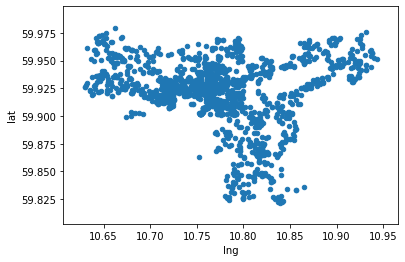

In [40]:
df = df2
df.plot(x='lng', y='lat', kind='scatter')

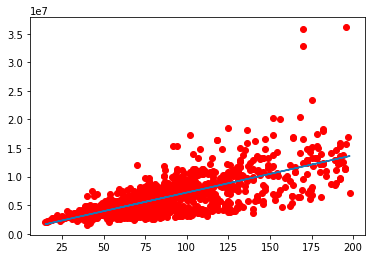

In [45]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
df['price'] = df.Totalpris.fillna(df.Prisantydning)
df['area'] = df.Bruksareal.fillna(df.Primærrom)
df['price_per_m2'] = df.price / df.area
#filtered = df.query('area == area and price == price')
#X = filtered.query('area < 200')[['area']]
#y = filtered.query('area < 200')[['price']]
#regressor = LinearRegression()
#regressor.fit(X, y)
#filtered['predicted_price'] = regressor.predict(filtered[['area']]).flatten()
#filtered['priceyness'] = np.log(filtered.price) - np.log(filtered.predicted_price)
#filtered.to_csv('oslo-akershus.csv')

plt.scatter(X, y, color='red')
plt.plot(X, regressor.predict(X))
plt.show()
#filtered.priceyness

<ipython-input-46-8eb066890970>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['priceyness'] = np.log(filtered.price) - np.log(filtered.predicted_price)  # line 2: filtered['priceyness'] = np.log(filtered.price) - np.log(filtered.predicted_price)


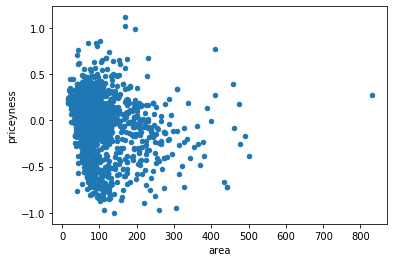

In [46]:
import numpy as np
filtered['priceyness'] = np.log(filtered.price) - np.log(filtered.predicted_price)
filtered.plot(x='area', y='priceyness', kind='scatter')

In [47]:
filtered.to_csv('fancy.csv')

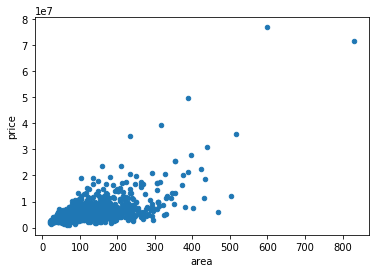

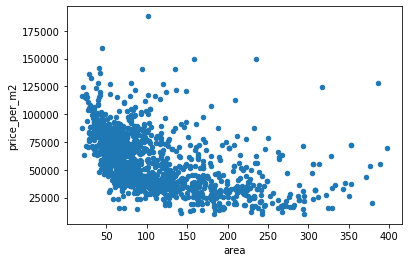

In [262]:
import matplotlib.pyplot as plt

df.plot(x='area', y='price', kind='scatter')
#plt.yscale('log')
df['price_per_m2'] = df.price / df.area
df.query('area < 400').plot(x='area', y='price_per_m2', kind='scatter')


In [31]:
df2 = df

In [414]:
df[df.columns[~df.isnull().any()]]

,Address,Boligtype,Eieform,FINN-kode,Prisantydning,Title,lat,lng
0,"Hyggeveien 6 C, 1178 Oslo",Enebolig,Eier (Selveier),155214978,11500000.0,"Innholdsrik enebolig, delikat og åpen design, ...",59.881200,10.796200
1,"Stallerudveien 91, 0693 Oslo",Leilighet,Andel,165902852,2200000.0,Fin 1-roms med alkove | Solrik vestvendt balko...,59.876100,10.843700
2,"Oppsaltoppen 16A, 0687 Oslo",Leilighet,Andel,165881951,3750000.0,Lekker 3-roms på Oppsal | Fyring/varmtvann ink...,59.898600,10.848100
3,"Frydenlundgata 10 B, 0169 Oslo",Leilighet,Eier (Selveier),121170118,8800000.0,"Ny, 3-roms loftsleilighet med eksklusivt preg,...",59.924522,10.737469
4,"Pilestredet Park 1, 0176 Oslo",Leilighet,Eier (Selveier),165905153,3350000.0,Lys og pen 1-roms leilighet med god standard o...,59.920900,10.737800
5,"Stovnerveien 36 E, 0982 Oslo",Enebolig,Eier (Selveier),154347018,7500000.0,Velholdt enebolig fra 2009 - Egen inngang i un...,59.952520,10.936776
6,"Knut Alvssons vei 25, 0574 Oslo",Leilighet,Andel,165061871,3200000.0,FASTPRIS! Oppussingsobjekt som enkelt kan gjør...,59.933327,10.780162
7,"Stålfjæra 44, 0975 Oslo",Leilighet,Eier (Selveier),161722757,3200000.0,Lekker 3-roms | Flott kjøkken fra 2017 | Markt...,59.950400,10.882900
8,"Mor Go`hjertas vei 13, 0469 Oslo",Leilighet,Andel,165837399,4390000.0,Sagene/Bjølsen: Lekker 3-roms med solrik vestv...,59.942040,10.764178
9,"Gamle Hovsetervei 2C, 0768 Oslo",Leilighet,Eier (Selveier),165836092,5950000.0,Lys og romslig 4-roms familieleilighet i barne...,59.947320,10.653983


In [166]:
d = soup.find_all(class_='panel')[3]
d.h1.text # title
d.p.text # address

'Conrad Hemsens vei 13H, 0287 Oslo'

In [210]:
soup.find_all(class_='panel')[5].text.replace('\xa0', '').split('\n') \
    |> map$(x -> x.strip()) \
    |> filter$(x -> x) \
    |> list

['Boligtype',
 'Leilighet',
 'Eieform',
 'Andel',
 'Soverom',
 '2',
 'Primærrom',
 '64 m²',
 'Bruksareal',
 '64 m²',
 'Etasje',
 '2',
 'Byggeår',
 '1983',
 'Energimerking',
 'F - oransje',
 'Rom',
 '3',
 'Renovert år',
 '2003',
 'Tomteareal',
 '9674 m²',
 'Bruttoareal',
 '71 m²',
 'Fellesformue',
 '40032 kr',
 'Formuesverdi',
 '1170000 kr',
 'Fasiliteter',
 'Balkong/Terrasse',
 'Parkett',
 'Peis/Ildsted',
 'Rolig',
 'Sentralt',
 'Turterreng',
 'Felleskostnader inkluderer',
 'Fellesutgifter inkluderer kapitalkostnader fellesgjeld, felles forsikring, kabel-TV/bredbånd, vaktmestertjenester, kommunale avgifter og strøm til fellesarealer.',
 'Omkostninger',
 'Totalkostnad: kr 1032,-Tinglysning av hjemmelsdok.:  kr 430,-Tinglysning av pantedok.: kr 430,-Attestgebyr: kr 172,-Totalkostnad: kr 1032,-',
 'Matrikkelinformasjon',
 'Kommunenr: 301',
 'Gårdsnr: 2',
 'Bruksnr: 1082',
 'Borettslag-navn: Ladegaardsøen Borettslag',
 'Borettslag-orgnummer: 952880764',
 'Borettslag-andelsnummer: 28']

In [279]:
soup = BeautifulSoup(requests.get('https://www.finn.no/realestate/homes/ad.html?finnkode=155214978').text)

In [282]:
soup.find_all(class_='panel') |> map$(x -> x.text.replace('\n', '').replace(' ', '')) |> list

['-VelkommentilHyggeveien6C-(1/51)Romsligogsolfyltstue,spisestueogåpenkjøkkenløsning.Enåpenløsninggirgodkommunikasjonmellometasjenssoner,oggjørdettetiletrommedhøytrivselsfaktor(2/51)BoligenliggergodttilbaketrukketfraHyggeveien.Storgarasjemedplasstilflerebileretterhverandre,samtstorasfaltertgårdsplass(3/51)Plantegning1.etasje(4/51)Åpenkjøkkenogspisestueløsningmedgodplasstilstortspisebord.Etfintstedåsamlebådefamilieogvenner.Deterosågodplasstilådekketillangbordvedstørrebegivenheter(5/51)Solrikogromsligstuemedgodplasstilsofagruppe.Utgangtiloverbyggetterrasseogmedvidereadkomsttilhagen(6/51)Spisestuemedgodplasstilstortspisebord.Etfintstedåsamlebådefamilieogvenner.Lunt,koseligogpraktiskkjøkkensomliggeriåpenløsningmotspisestuen(7/51)Kjøkkenogspisestueiåpenløsning.Hyggeligplassåinntaforkostenvedkjøkkenøyen.Peisovnengirekstrahyggeogvarmepåkaldehøst-ogvinterkvelder.(8/51)Kjøkkenetfra2016ogerutrustetmedoverskapi2høydersomgirekstragodskap-ogbenkeplass,samtintegrertehvitevarer(9/51)Lunt,koseligogpra

<p class="u-caption">Hyggeveien 6 C, 1178 Oslo</p>

In [228]:
d5.find_all('dl')[1].find_all('dt') |> map$(x -> x.text) |> list

['Rom', 'Renovert år', 'Tomteareal', 'Bruttoareal']

In [244]:
from functools import reduce

soup.find_all('dl') |> map$(dl -> dict(zip(
    dl.find_all('dt') |> map$(x -> x.text.replace('\n', '').replace('\xa0', '').strip()) |> list,
    dl.find_all('dd') |> map$(x -> x.text.replace('\n', '').replace('\xa0', '').strip()) |> list
))) |> reduce$((a, b) -> {**a, **b})

{'Fellesgjeld': '208076 kr',
 'Omkostninger': '1032 kr',
 'Totalpris': '3959108 kr',
 'Felleskost/mnd.': '3800 kr',
 'Boligtype': 'Leilighet',
 'Eieform': 'Andel',
 'Soverom': '2',
 'Primærrom': '64 m²',
 'Bruksareal': '64 m²',
 'Etasje': '2',
 'Byggeår': '1983',
 'Energimerking': 'F - oransje',
 'Rom': '3',
 'Renovert år': '2003',
 'Tomteareal': '9674 m²',
 'Bruttoareal': '71 m²',
 'Fellesformue': '40032 kr',
 'Formuesverdi': '1170000 kr',
 'Telefon': '473 55 878',
 'Mobil': '473 55 878'}

In [251]:
zip([1,2,3,3],[1,2,34,4]) |> list

[(1, 1), (2, 2), (3, 34), (3, 4)]

In [313]:
re.findall('(?:Pris|Prisa)(\d+)kr', 'Prisa200kr')

['200']